In [9]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [10]:
class deepFuzzy:
    W = dict()
    b = dict()
    A = dict()
    Z = dict()
    grads = dict()
    def __init__(self,layers, x_train,x_test,y_train,y_test):
        self.layers = layers
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.L = len(layers)
    def initialize(self, initializer = 'random'):
        for i in range(1,self.L):
            self.W["W" + str(i)] = np.random.randn(self.layers[i][0],self.layers[i-1][0])*0.01
            self.b["b" + str(i)] = np.random.randn(self.layers[i][0],1)
    
    ###FORWARD PROP###
    @staticmethod
    def forward(A,W,b):
        Z = np.dot(W,A) + b
        return Z
    @staticmethod        
    def forwardAct(A,W,b,activation = 'sigmoid'):
        Z, linear_cache = deepfuzzy.forward(A,W,b)
        activation_cache = Z
        if activation == 'sigmoid':
            A_next = sigmoid(Z)
        if activation == 'relu':
            A_next = relu(Z)
        return A_next, Z
    
    def forwardProp(self):
        A = self.x_train
        self.A["A" + str(0)] = A 
        for i in range (1,self.L):
            A, Z = deepfuzzy.forwardAct(A, self.W[str(i)], self.b[str(i)], activation = layers[i-1][1])
            self.A["A" + str(i)] = A 
            self.Z["Z" + str(i)] = Z
            print(A.shape)

    def compute_cost(self):
        m = self.y_train.shape[1]
        Y = self.y_train
        AL = self.A["A" + str(self.L-1)]
        print(Y.shape)
        print(AL.shape)
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
        cost = np.squeeze(cost) 
        return cost
    
    ###BACKWARD PROP###
    @staticmethod    
    def backward(dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = 1.0/m * dZ.dot(A_prev.T)
        db = 1.0/m * np.sum(dZ,axis=1,keepdims=True)
        dA_prev = W.T.dot(dZ)
        return dA_prev, dW, db
    @staticmethod
    def backwardAct(dA, cache, activation):
        linear_cache, activation_cache = cache
        if activation == "relu":
            dZ = relu_backward(dA, activation_cache)
            dA_prev, dW, db = deepfuzzy.backward(dZ, linear_cache)
        elif activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = deepfuzzy.backward(dZ, linear_cache)
        return dA_prev, dW, db
    
    def backwardProp(self):
        L = self.L
        AL = self.A["A" + str(L-1)]
        m = AL.shape[1]
        Y = self.y_train.reshape(AL.shape) 
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - self.AL))
        self.grads["dA" + str(L+1)]
#         current_cache = self.caches[L-1]
#         self.grads["dA" + str(L)], self.grads["dW" + str(L)], self.grads["db" + str(L)] = deepfuzzy.backwardAct(dAL, current_cache, "sigmoid")
        for l in reversed(range(L)):
            current_cache = (self.Z["Z" + str(l)],(self.A["A"+str(l)],self.W["W"+str(l)],self.b["b"+str(l)]))
            dA_prev_temp, dW_temp, db_temp = deepfuzzy.backwardAct(self.grads["dA"+str(l+2)], current_cache, activation = layers[i-1][1])
            self.grads["dA" + str(l + 1)] = dA_prev_temp
            self.grads["dW" + str(l + 1)] = dW_temp
            self.grads["db" + str(l + 1)] = db_temp
    def update_parameters(self,learning_rate):
        for l in range(self.L):
            self.W[str(l+1)] = self.W[str(l+1)] - learning_rate * self.grads["dW" + str(l+1)]
            self.b[str(l+1)] = self.b[str(l+1)] - learning_rate * self.grads["db" + str(l+1)]


In [17]:
layers = [[12288,'relu'],[20, 'relu'],[7, 'relu'],[5, 'relu'],[1,'sigmoid']]

In [12]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [13]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


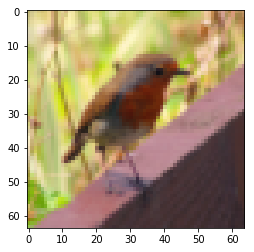

In [14]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [15]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [16]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [19]:
m = deepFuzzy(layers,train_x,test_x,train_y,test_y)

In [20]:
m.initialize()